# ABEL linac tracking example

By Carl A. Lindstrøm (University of Oslo), 8 Sep 2023

### Import ABEL framework

In [1]:
import sys
sys.path.append('../../ABEL/')
from abel import *

%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import time
import scipy.constants as SI 
import abel.utilities.plasma_physics as pp
import matplotlib.pyplot as plt

### Define the linac and beams

In [3]:
driver = SourceBasic()
driver.charge = -2.7e10 * SI.e # [C]
driver.energy = 31.25e9 # [eV]/
driver.rel_energy_spread = 0.01
driver.bunch_length = 42e-6 # [m]
driver.z_offset = 300e-6 # [m]
driver.emit_nx, driver.emit_ny = 10e-6, 10e-6 # [m rad]
driver.beta_x, driver.beta_y = 30e-3, 30e-3 # [m]
driver.num_particles = 100000
driver.jitter.x = 0e-9 # [m]
driver.jitter.y = 0e-9 # [m]
driver.symmetrize = True

# define stage
stage = StageQuasistatic2d()
stage.driver_source = driver
stage.nom_energy_gain = 31.9e9 # [eV] 31.9e9 
stage.length = 5 # [m]
stage.plasma_density = 7e21 # [m^-3]
stage.ramp_beta_mag = 5
stage.enable_radiation_reaction = True

# define first stage (half length)
first_stage = StageQuasistatic2d()
first_stage.driver_source = stage.driver_source
first_stage.nom_energy_gain = stage.nom_energy_gain/2
first_stage.length = stage.length/2
first_stage.plasma_density = stage.plasma_density
first_stage.ramp_beta_mag = stage.ramp_beta_mag
first_stage.enable_radiation_reaction = stage.enable_radiation_reaction

# define beam
source = SourceBasic()
source.charge = -1e10 * SI.e # [C]
source.energy = 5e9 # [eV]
source.rel_energy_spread = 0.01
source.bunch_length = 18e-6 # [m]
source.z_offset = -33e-6 # [m]
source.emit_nx, source.emit_ny = 160e-6, 0.56e-6 # [m rad]
source.beta_x = stage.matched_beta_function(source.energy)
source.beta_y = source.beta_x
source.num_particles = 50000
source.jitter.t = driver.jitter.t
source.symmetrize = True

# define interstage
interstage = InterstageBasic()
interstage.beta0 = lambda E: stage.matched_beta_function(E)
interstage.dipole_length = lambda E: 1 * np.sqrt(E/10e9) # [m(eV)]
interstage.dipole_field = 0.0 # [T]

# beam delivery system
bds = BeamDeliverySystemBasic()
bds.beta_x, bds.beta_y = 8e-3, 0.4e-3 # [m]
bds.bunch_length = 0.75 * bds.beta_y

# define linac
linac = Linac()
linac.source = source
linac.stage = stage
linac.first_stage = first_stage
linac.interstage = interstage
linac.num_stages = 16*3
shots = 1

### Run simulations

In [4]:
start = time.time()
linac.run(f'linac_example_old_params_RR_{stage.enable_radiation_reaction}_stages_{linac.num_stages}', num_shots=shots, overwrite=False, parallel=False);
end = time.time()

print((end - start)/60, ' min') # time in minutes

Tracking element 1 (SourceBasic, stage 0, s = 0.0 m, 5.0 GeV, -1.60 nC, 1.0% rms, 158.0/0.6 µm-rad)
Number of cores: 5
Tracking element 2 (StageQuasistatic2d, stage 1, s = 2.5 m, 21.0 GeV, -1.60 nC, 3.8% rms, 157.9/0.6 µm-rad)
Tracking element 3 (InterstageBasic, stage 1, s = 9.4 m, 21.0 GeV, -1.60 nC, 3.8% rms, 157.9/0.6 µm-rad)
Number of cores: 5
Tracking element 4 (StageQuasistatic2d, stage 2, s = 14.4 m, 53.1 GeV, -1.60 nC, 4.5% rms, 157.8/0.6 µm-rad)
Tracking element 5 (InterstageBasic, stage 2, s = 25.4 m, 53.1 GeV, -1.60 nC, 4.5% rms, 157.8/0.6 µm-rad)
Number of cores: 5
Tracking element 6 (StageQuasistatic2d, stage 3, s = 30.4 m, 85.2 GeV, -1.60 nC, 4.7% rms, 157.7/0.6 µm-rad)
Tracking element 7 (InterstageBasic, stage 3, s = 44.4 m, 85.2 GeV, -1.60 nC, 4.7% rms, 157.6/0.6 µm-rad)
Number of cores: 5
Tracking element 8 (StageQuasistatic2d, stage 4, s = 49.4 m, 117.2 GeV, -1.60 nC, 4.7% rms, 157.4/0.6 µm-rad)
Tracking element 9 (InterstageBasic, stage 4, s = 65.7 m, 117.2 GeV, -1

### Plot the wakefield

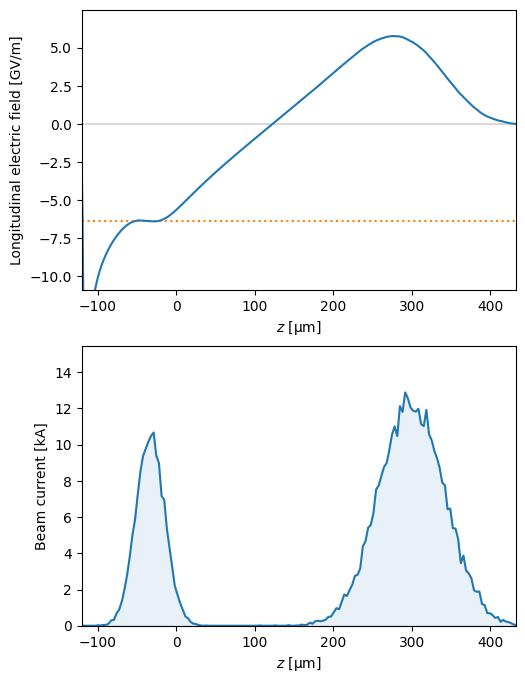

In [5]:
# plot the first-stage wakefield
linac.stages[0].plot_wakefield()

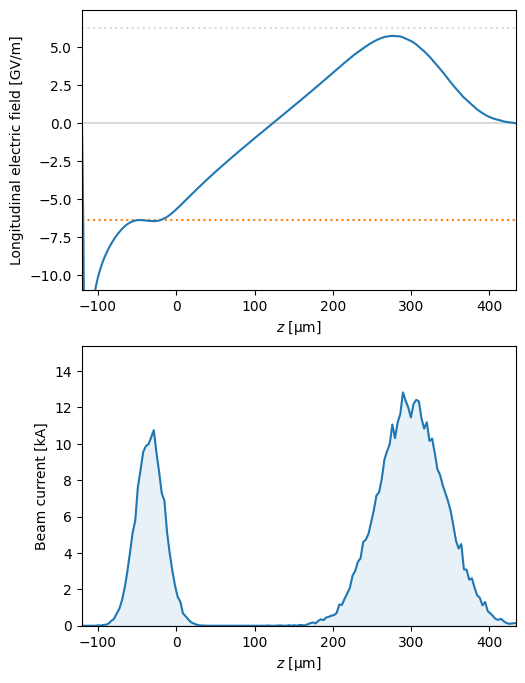

In [6]:
# plot the last-stage wakefield
linac.stages[-1].plot_wakefield()

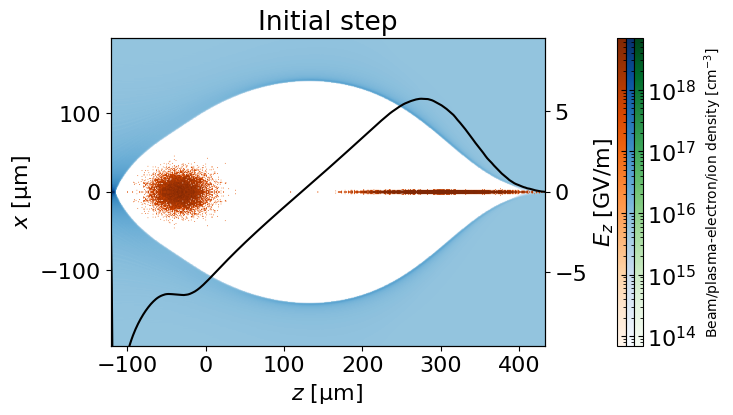

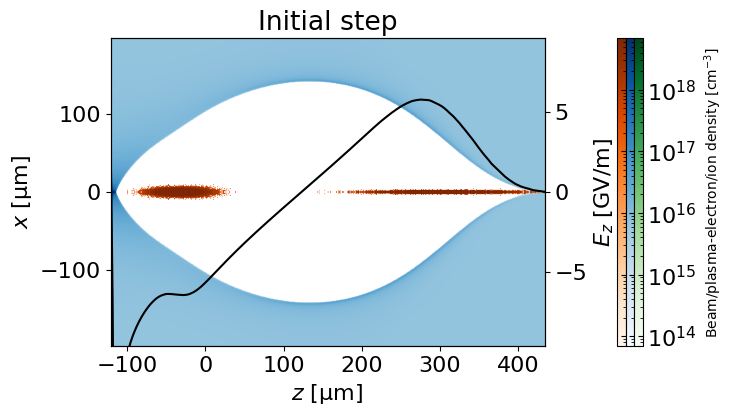

In [7]:
wake0 = linac.stages[0].plot_wake()
wake_final = linac.stages[-1].plot_wake()
#wake0.savefig(f'Plots/Old_Params/wake0_old_params_RR_{stage.enable_radiation_reaction}_stages_{linac.num_stages}', bbox_inches='tight')
#wake_final.savefig(f'Plots/Old_Params/wake_final_old_params_RR_{stage.enable_radiation_reaction}_stages_{linac.num_stages}', bbox_inches='tight')

In [8]:
#fig = linac.stages[0].plot_evolution()
fig_last = linac.stages[-1].plot_evolution()

No evolution calculated


### Plot beam evolution and survey

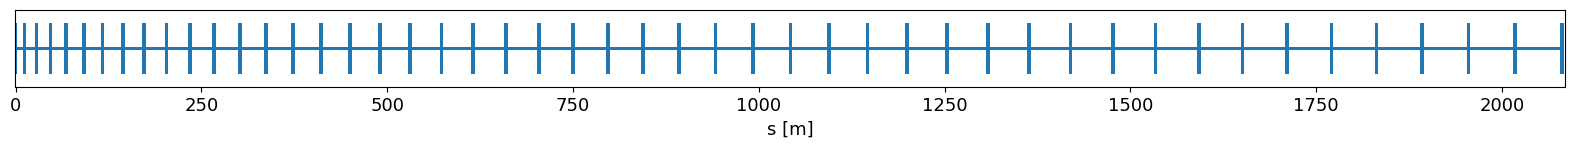

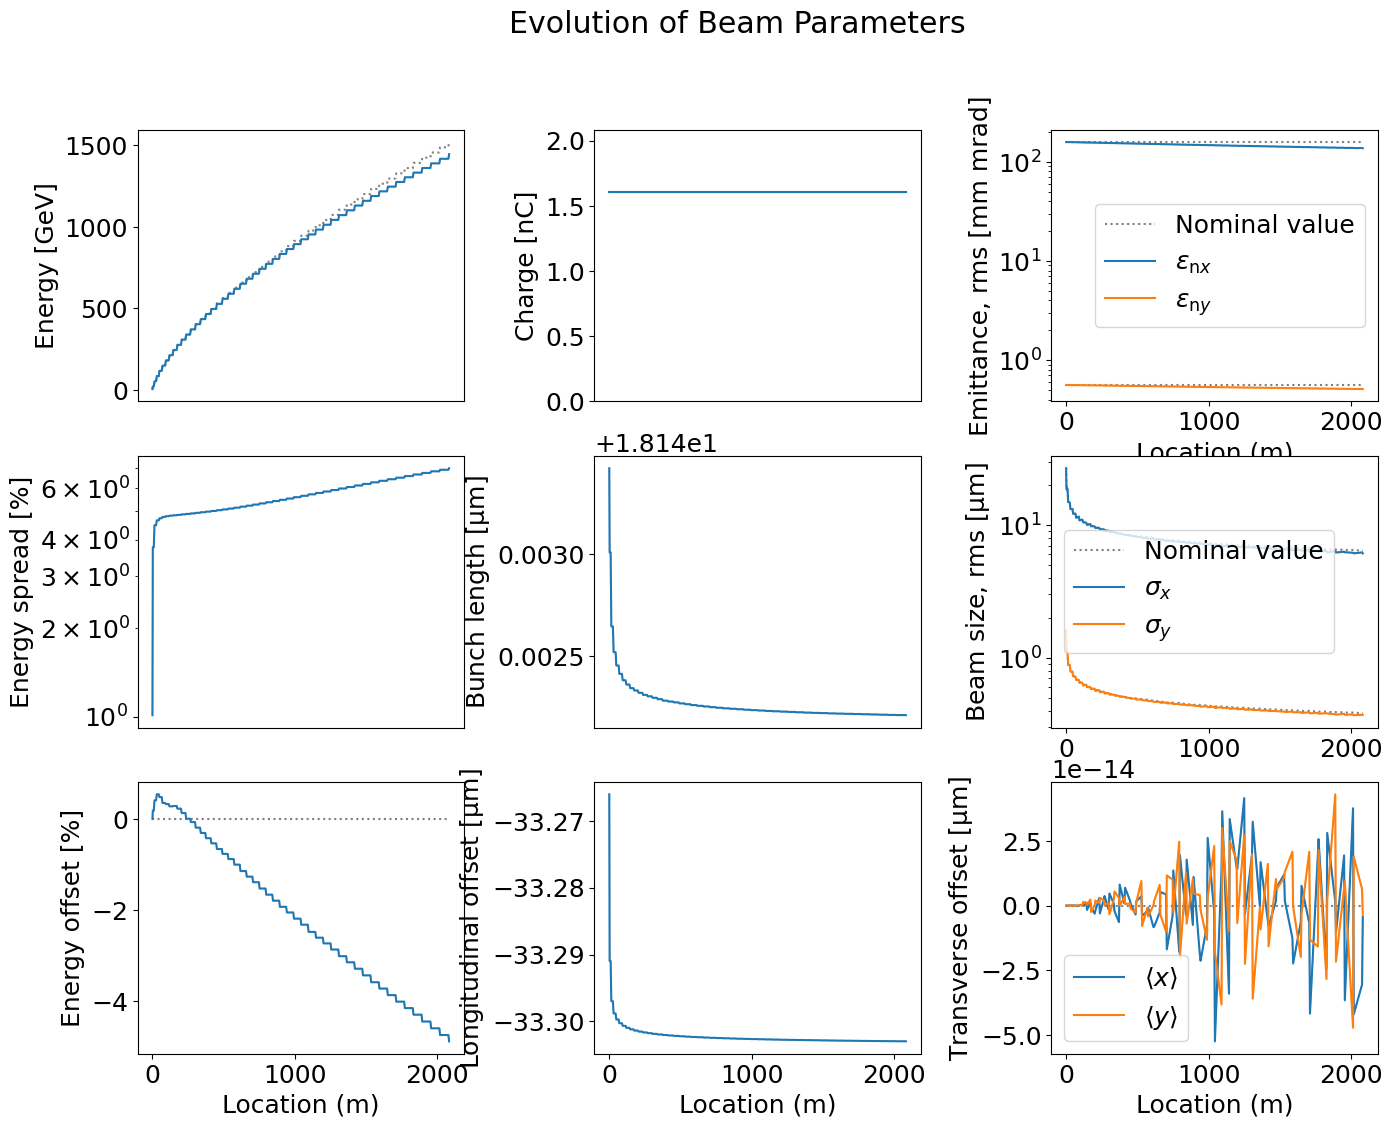

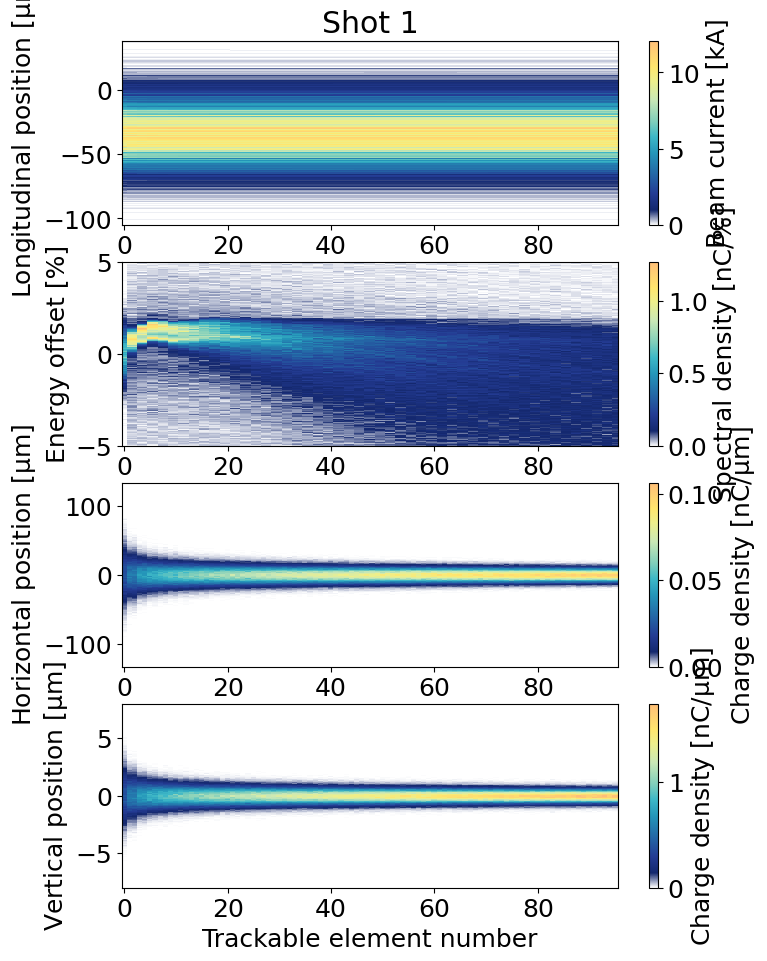

In [9]:
# plot linac survey
linac.plot_survey()

# plot beam evolution
beam_evolution = linac.plot_evolution(use_stage_nums=False)
#beam_evolution.savefig(f"Plots/Old_Params/beam_evolution_old_params_RR_{stage.enable_radiation_reaction}\
#_stages_{linac.num_stages}.png", bbox_inches='tight')

linac[0].plot_waterfalls()


In [10]:
gif = linac.animate_lps()

![](run_data/linac_example/plots/lps_shot0.gif)

In [11]:
stage_num = 15
shot_num = 0
stage_tracked = linac[shot_num].stages[stage_num]  # Get a specific acceleration stage in a linac. Zero indexing.
beam_out = linac[shot_num].get_beam(stage_num*2+1)  # Get the corresponding beam after the acceleration stage. Zero indexing.

In [12]:
stage_tracked.print_current_summary(stage_tracked.drive_beam, linac.initial_beam, beam_out)

AttributeError: 'StageQuasistatic2d' object has no attribute 'print_current_summary'